In [77]:
import pandas as pd
import numpy as np
import difflib
from os.path import join
from matplotlib import pyplot as plt

In [ ]:
# placeholder_dataset = "../results/placeholder_dataset/libraries.csv"
# baseline_results = "../results_llm/output_baseline_libraries-basic.csv"
# error_results = "../results_llm/output_error_libraries-basic.csv"

# placeholder_dataset = "../results/placeholder_dataset/dafnyVMC.csv"
baseline_results = "../results_llm/output_baseline_vmc-basic.csv"
error_results = "../results_llm/output_error_vmc-basic.csv"

# placeholder_dataset = pd.read_csv(placeholder_dataset)
baseline_results = pd.read_csv(baseline_results)
error_results = pd.read_csv(error_results)

results = error_results
# results = baseline_results

print(results.columns)
# print(results.head())

Index(['Index', 'Original Method File', 'Original Method',
       'Original Method Time', 'Original Method Result',
       'Original Result File', 'Original Error Message',
       'Original Error Message File', 'New Method File', 'New Method',
       'New Method Time', 'New Method Result', 'New Method Result File',
       'New Method Error Message', 'New Method Error Message File',
       'Prompt File', 'Prompt Length', 'Prompt Index', 'Prompt name',
       'Error message', 'Feedback', 'Try', 'Number placeholders',
       'Placeholder position', 'Diff', 'Url'],
      dtype='object')


In [81]:
def trial_stats(exp_results, trial_idx):
    initial_method = exp_results.loc[trial_idx, "Original Method File"]
    initial_method = join("..", initial_method)
    with open(initial_method, "r") as f:
        initial_method = f.read()

    new_method = exp_results.loc[trial_idx, "New Method File"]
    new_method = join("..", new_method)
    with open(new_method, "r") as f:
        new_method = f.read()

    diff = difflib.ndiff(initial_method.splitlines(), new_method.splitlines())
    diff_line_nos = []
    for i, line in enumerate(diff):
        if line.startswith("  "):
            continue
        return i + 1
    return None


def original_diff_line(exp_results, placeholder_dataset):
    # obtain the method name from any row
    method_name = exp_results.at[exp_results.index[0], "Original Method"]
    # lookup the method name in the placeholder dataset
    with_method = placeholder_dataset[
        placeholder_dataset["Original Method"] == method_name
    ]
    # print(with_method)
    # obtain the original file from any row
    original_file = with_method.at[with_method.index[0], "Original File"]
    original_file = join("..", original_file)
    with open(original_file, "r") as f:
        original_file = f.read()

    incomplete_file = exp_results.loc[0, "Original Method File"]
    incomplete_file = join("..", incomplete_file)
    with open(incomplete_file, "r") as f:
        incomplete_file = f.read()

    diff = difflib.ndiff(original_file.splitlines(), incomplete_file.splitlines())
    for i, line in enumerate(diff):
        if line.startswith("  "):
            continue
        return i + 1
    return None


def experiment_stats(results, exp_idx, placeholder_dataset):
    exp_results = results[results.Index == exp_idx]
    exp_results.index = range(len(exp_results))

    true_diff_line = original_diff_line(exp_results, placeholder_dataset)
    # print(f"Original Diff Line: {true_diff_line}")

    diff_lines = []
    for trial_idx in range(len(exp_results)):
        diff_line = trial_stats(exp_results, trial_idx)
        if diff_line is None:
            continue
        diff_lines.append(diff_line)

    # compute rmse between true_diff_line and diff_lines
    diff_lines = np.array(diff_lines)
    # mean_diff = np.sqrt(np.mean((diff_lines - true_diff_line)**2))
    mean_diff = np.mean(np.abs(diff_lines - true_diff_line))

    std = np.std(diff_lines)

    return mean_diff, std


def analyze_results(results, placeholder_dataset):
    # obtain all indices from the results
    exp_indices = results.Index.unique()
    rmses, stds = [], []
    for exp_idx in exp_indices:
        rmse, std = experiment_stats(results, exp_idx, placeholder_dataset)
        rmses.append(rmse)
        stds.append(std)
    return rmses, stds

In [ ]:
datasets = ["libraries", "DafnyVMC", "cedar"]
results = {}
for bench in datasets:
  res = bench
  if bench = "DafnyVMC":
    res = "vmc"
  baseline_results = f"../results_llm/output_baseline_{res}-basic.csv"
  error_results = f"../results_llm/output_error_{res}-basic.csv"

  placeholder_dataset = pd.read_csv(placeholder_dataset)
  baseline_results = pd.read_csv(baseline_results)
  error_results = pd.read_csv(error_results)
  baselines_stats, baseline_stds = analyze_results(baseline_results, placeholder_dataset)
  error_stats, error_stds = analyze_results(error_results, placeholder_dataset)
  


Baseline median RMSE: 3.9
Error median RMSE: 2.0


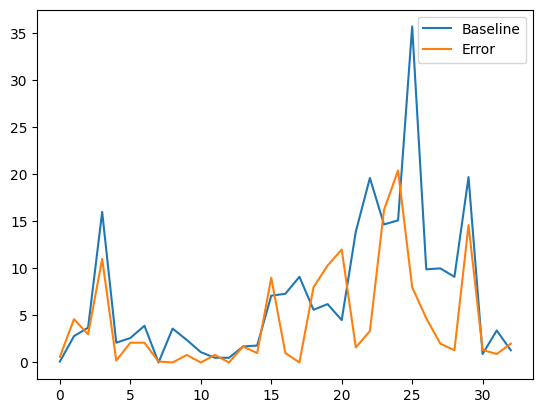

Baseline median Std: 4.737087712930805
Error median Std: 1.3453624047073711


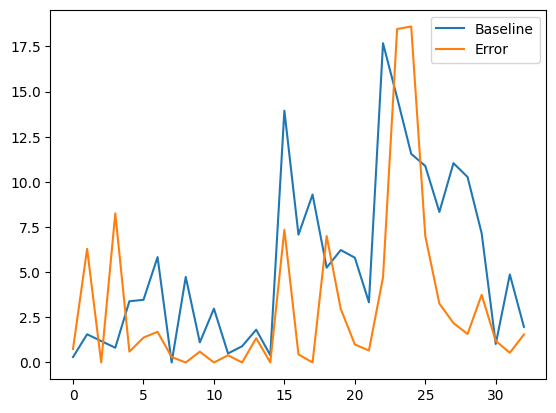

In [82]:
baseline_stats, baseline_stds = analyze_results(baseline_results)
error_stats, error_stds = analyze_results(error_results)

print(f"Baseline median RMSE: {np.median(baseline_stats)}")
print(f"Error median RMSE: {np.median(error_stats)}")
# plot both stats on the same plot, each as a line
plt.plot(baseline_stats, label="Baseline")
plt.plot(error_stats, label="Error")
plt.legend()
plt.show()

print(f"Baseline median Std: {np.median(baseline_stds)}")
print(f"Error median Std: {np.median(error_stds)}")
# plot both stds on the same plot, each as a line
plt.plot(baseline_stds, label="Baseline")
plt.plot(error_stds, label="Error")
plt.legend()
plt.show()